In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as  tf
from tensorflow import keras
tf.__version__

'2.19.0'

## 소규모 데이터셋에서 컨브넷(CNN) 훈련

### 예제. 캐글의 dogs-vs-cats 데이터

- 캐글에서 2013년 후반 컴퓨터비전 경연대회를 위해 만들어진 데이터셋
- https://www.kaggle.com/competitions/dogs-vs-cats/
- 812MB

### 1. 데이터 준비

#### Kaggle API를 이용하여 파일 다운로드

**Kaggle API 키 생성 및 저장**

1. Kaggle 사이트 로그인
2. Account 페이지로 이동
3. Setting 메뉴 선택
4. API 섹션에서 [Create New Token]선택하여 토큰 파일 kaggle.json 생성
5. kaggle.json 파일을 사용자계정폴더 아래 /.kaggle/ 폴더를 생성하여 저장
  

**다음 명령어로 데이터 파일 다운로드**

#### 압축파일 풀기

In [3]:
!kaggle competitions download -c dogs-vs-cats -p c:/workspaces/07_DL/data/


  0%|          | 0.00/812M [00:00<?, ?B/s]
 14%|█▍        | 113M/812M [00:00<00:00, 1.17GB/s]
 28%|██▊       | 225M/812M [00:00<00:00, 919MB/s] 
 39%|███▉      | 316M/812M [00:00<00:00, 569MB/s]
 47%|████▋     | 382M/812M [00:00<00:00, 464MB/s]
 55%|█████▍    | 444M/812M [00:00<00:00, 490MB/s]
 61%|██████    | 497M/812M [00:00<00:00, 467MB/s]
 69%|██████▊   | 557M/812M [00:01<00:00, 497MB/s]
 75%|███████▍  | 608M/812M [00:01<00:00, 484MB/s]
 83%|████████▎ | 672M/812M [00:01<00:00, 531MB/s]
 92%|█████████▏| 747M/812M [00:01<00:00, 597MB/s]
100%|██████████| 812M/812M [00:01<00:00, 570MB/s]


#### 이미지를 훈련, 검증, 테스트 디렉토리로 복사하기
- train 폴더에 cat, dog 폴더를 생성하고 각각 1000개씩 이미지 저장
- validation 폴더에 cat, dog 폴더를 생성하고 각각 500개씩 이미지 저장
- test 폴더에 cat, dog 폴더를 생성하고 각각 1000개씩 이미지 저장

In [1]:
import zipfile

In [4]:
base = 'data/'
path_to_zip = base + 'dogs-vs-cats.zip'
dir_to_extract = base + 'dogs-vs-cats'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

In [5]:
path_to_zip = base + 'dogs-vs-cats/train.zip'
dir_to_extract = base + 'dogs-vs-cats'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

#### 이미지를 훈련(train), 검증(val), 테스트(test) 디렉토리로 복사하기

- 폴더명: cats_vs_dogs_small
- train 폴더에 cat, dog 폴더를 생성하고 각각 1000개씩 이미지 저장
- validation 폴더에 cat, dog 폴더를 생성하고 각각 500개씩 이미지 저장
- test 폴더에 cat, dog 폴더를 생성하고 각각 1000개씩 이미지 저장

In [9]:
import os, shutil, pathlib

In [7]:
pathlib.Path(base + 'dogs-vs-cats/train')

WindowsPath('data/dogs-vs-cats/train')

In [8]:
print(pathlib.Path(base + 'dogs-vs-cats/train'))

data\dogs-vs-cats\train


In [13]:
def make_subset(subset_name, start_idx, end_idx):
    src_path = pathlib.Path(base + 'dogs-vs-cats/train')
    des_path = pathlib.Path(base + 'cats_vs_dogs_small')
    for cate in ('cat', 'dog'):
        p = des_path / subset_name / cate
        if not p.exists():
            p.mkdir(parents=True, exist_ok=True)
        fnames = [f'{cate}.{i}.jpg' for i in range(start_idx, end_idx)]
        for fname in fnames:
            shutil.copyfile(src=src_path/fname, dst=p/fname)
        print(f'## 경로 {p}에 파일복사 완료!')

In [14]:
make_subset('train', start_idx=0, end_idx=1000)
make_subset('validation', start_idx=1000, end_idx=1500)
make_subset('test', start_idx=1500, end_idx=2500)

## 경로 data\cats_vs_dogs_small\train\cat에 파일복사 완료!
## 경로 data\cats_vs_dogs_small\train\dog에 파일복사 완료!
## 경로 data\cats_vs_dogs_small\validation\cat에 파일복사 완료!
## 경로 data\cats_vs_dogs_small\validation\dog에 파일복사 완료!
## 경로 data\cats_vs_dogs_small\test\cat에 파일복사 완료!
## 경로 data\cats_vs_dogs_small\test\dog에 파일복사 완료!


### 2. 모델 만들기

In [2]:
from keras import layers, models

#### 모델 build

- 일반적인 모델 구조 사용
- 180x180 크기에서 7x7 크기의 특성 맵으로 줄임

In [3]:
# 함수형 Api 를 이용해 모델 정의

inputs = layers.Input(shape=(180,180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs, outputs=outputs)

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#### 모델 컴파일

In [7]:
from keras.preprocessing import image_dataset_from_directory

In [10]:
base_path = 'data/cats_vs_dogs_small'
p = pathlib.Path(base_path)
train_dir = os.path.join(p, 'train')
val_dir = os.path.join(p, 'validation')
test_dir = os.path.join(p, 'test')
print(train_dir)
print(val_dir)
print(test_dir)

data\cats_vs_dogs_small\train
data\cats_vs_dogs_small\validation
data\cats_vs_dogs_small\test


In [11]:
train_ds = image_dataset_from_directory(train_dir, image_size=(180,180), batch_size=32)
val_ds = image_dataset_from_directory(val_dir, image_size=(180,180), batch_size=32)
test_ds = image_dataset_from_directory(test_dir, image_size=(180,180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 3. 데이터 전처리

- 이미지 파일 읽기
- JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩
- 부동 소수점 타입의 텐서로 변환
- 동일한 크기의 이미지로 변경(180x180)
- 배치로 묶기(하나의 배치를 32개 이미지로 구성)

#### `image_dataset_from_directory()` 함수를 사용하여 이미지 읽기

- 자동으로 디스크에 있는 이미지 파일을 자동으로 전처리된 텐서의 배치로 변환하는 데이터 파이프라인을 빠르게 구성
- image_dataset_from_directory() 수행 내용
    - directory의 서브디렉터리를 찾음
        - 각 서브디렉터리에는 한 클래스에 해당하는 이미지가 담겨있다고 가정
    - 각 서브디렉터리에 있는 이미지 파일을 인덱싱
    - 파일을 읽고, 순서를 섞고, 텐서로 디코딩하고, 동일 크기로 변경하고, 배치로 묶어 준 td.data.Dataset 객체를 만들어 반환
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

#### `Dataset`이 반환하는 데이터와 레이블 크기 확인하기

In [12]:
i = 0
for data_batch, label_batch in train_ds:
    print(f'data batch size: {data_batch.shape}')
    print(f'label batch size: {label_batch.shape}')
    print(label_batch)
    i+=1
    if i == 2:
        break

data batch size: (32, 180, 180, 3)
label batch size: (32,)
tf.Tensor([0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1], shape=(32,), dtype=int32)
data batch size: (32, 180, 180, 3)
label batch size: (32,)
tf.Tensor([1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1], shape=(32,), dtype=int32)


#### `Dataset`을 사용해 모델 훈련하기

In [13]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 816ms/step - accuracy: 0.5240 - loss: 0.6972 - val_accuracy: 0.5950 - val_loss: 0.6907
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 810ms/step - accuracy: 0.5410 - loss: 0.7005 - val_accuracy: 0.5390 - val_loss: 0.6827
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 818ms/step - accuracy: 0.5930 - loss: 0.6743 - val_accuracy: 0.5150 - val_loss: 0.6942
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 809ms/step - accuracy: 0.6250 - loss: 0.6506 - val_accuracy: 0.5780 - val_loss: 0.7092
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 0.6605 - loss: 0.6223 - val_accuracy: 0.6850 - val_loss: 0.5957
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 811ms/step - accuracy: 0.6890 - loss: 0.5905 - val_accuracy: 0.6970 - val_loss: 0.5843
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 751ms/step - accuracy: 0.7265 - loss: 0.5364 - val_accuracy: 0.6410 - val_loss: 0.6285
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.7490 - loss: 0.5190 - val_accu

#### 훈련 정확도와 손실 그래프 그리기

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [ModelCheckpoint(filepath='model/CNN_cats_dogs01.keras', monitor='val_loss',
                             save_best_only=True)
]
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 751ms/step - accuracy: 0.9870 - loss: 0.0454 - val_accuracy: 0.7160 - val_loss: 2.5449
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 816ms/step - accuracy: 0.9795 - loss: 0.0645 - val_accuracy: 0.7090 - val_loss: 2.7265
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 0.9880 - loss: 0.0397 - val_accuracy: 0.7290 - val_loss: 2.1035
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 752ms/step - accuracy: 0.9940 - loss: 0.0169 - val_accuracy: 0.7200 - val_loss: 2.4384
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 760ms/step - accuracy: 0.9900 - loss: 0.0355 - val_accuracy: 0.7190 - val_loss: 2.4633
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 751ms/step - accuracy: 0.9935 - loss: 0.0211 - val_accuracy: 0.7420 - val_loss: 2.5121
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 811ms/step - accuracy: 0.9885 - loss: 0.0366 - val_accuracy: 0.7370 - val_loss: 2.4177
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 812ms/step - accuracy: 0.9960 - loss: 0.0276 - val_accu

KeyboardInterrupt: 

#### 테스트 세트에서 모델 평가하기

In [ ]:
from keras.models import load_model

test_model = load_model('model/CNN_cats_dogs01.keras')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f'{test_loss:.4f}, {test_acc:.4f}')

[결과]
- 테스트 정확도 : 약 70%
- 훈련데이터수 작아서 과대적합 발생
- 작은 데이터? => 수백개 ~ 수만개 사이
- 과대적합 방지 : 드롭아웃, 규제, 데이터 추가

### 4. 데이터 증식(augmentation) 사용하기

- 데이터 증식은 기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법
- 여러 가지 랜덤한 변환을 적용하여 샘플을 늘림
- 훈련할 때 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표
- 케라스에서는 모델 시작 부분에 여러 개의 **데이터 증식 층(data augmentation layer)** 을 추가할 수 있음

#### 컨브넷에 추가할 데이터 증식 단계 정의하기

In [17]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

- RandomFlip('horizontal') : 좌우반전('vertical':상하반전, 'gorizontal_and_vertical' : 좌우/상하반전)
- RandomRotation(0.1) : [-10%, +10%] 범위 내에서 랜덤한 값만큼 회전 (-36도, 36도)
- RandomZoom(0.2) : [-20%, +20%] 범위 내에서 랜덤한 비율만큼 이미지 확대/축

In [18]:
data_aug = models.Sequential([RandomFlip('horizontal'), RandomRotation(0.1), RandomZoom(0.2)])

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

#### 랜덤하게 증식된 훈련 이미지 출력하기

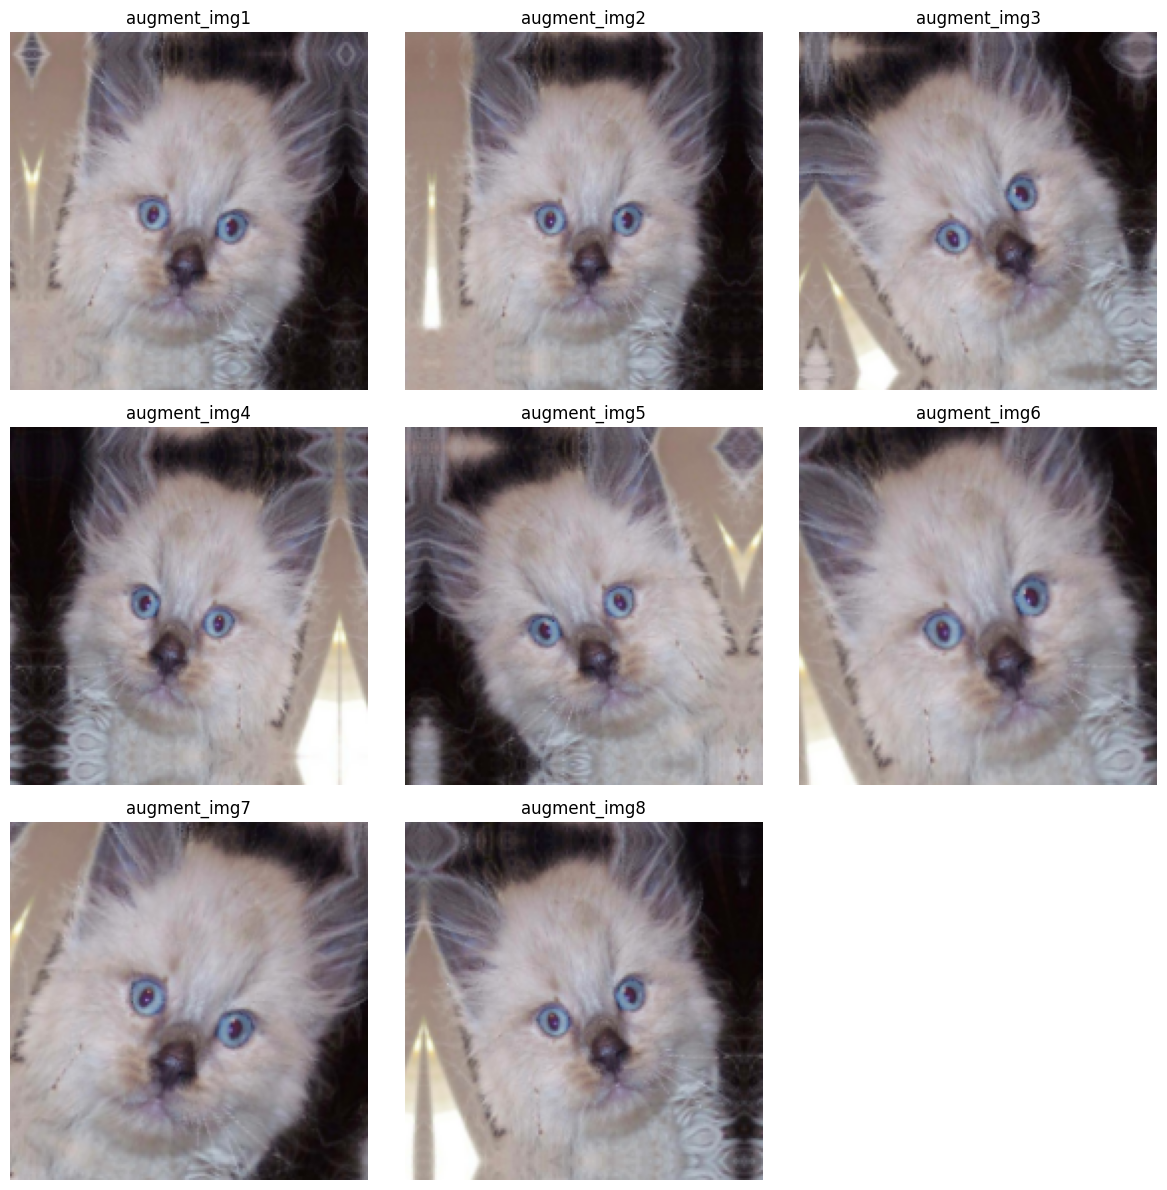

In [45]:
plt.figure(figsize=(12,12))
for img, _ in train_ds.take(1):
    plt.subplot(3,3,1)
    plt.imshow(img[0].numpy().astype('uint8'))
    for i in range(1,9):
        plt.subplot(3,3,i)
        aug_img = data_aug(img)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f'augment_img{i}')
plt.tight_layout()
plt.show()

In [46]:
for img, _ in train_ds.take(1):
    print(type(img[0]))
    print(img[0].numpy().dtype)
    print(img[0].numpy().astype('uint8').shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
float32
(180, 180, 3)


#### 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

In [ ]:
# 이미지 증식을 포함한 모델
inputs = layers.Input(shape=(180,180, 3))
x = data_aug(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs, outputs=outputs)
model.compilt(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#### 컨브넷 훈련하기

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',
                          patience=7,
                          verbose=1)

callbacks = [ModelCheckpoint(filepath='model/CNN_cats_dogs02_aug.keras', monitor='val_loss',
                             save_best_only=True)
]
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[callbacks,earlystop],
                   verbose=1)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 807ms/step - accuracy: 0.9925 - loss: 0.0255 - val_accuracy: 0.7360 - val_loss: 3.8662
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 809ms/step - accuracy: 0.9880 - loss: 0.0346 - val_accuracy: 0.6840 - val_loss: 5.2753
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 808ms/step - accuracy: 0.9955 - loss: 0.0236 - val_accuracy: 0.7420 - val_loss: 3.8618
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 810ms/step - accuracy: 0.9935 - loss: 0.0317 - val_accuracy: 0.7530 - val_loss: 3.7060
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 808ms/step - accuracy: 0.9885 - loss: 0.0392 - val_accuracy: 0.7200 - val_loss: 4.5956
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 821ms/step - accuracy: 0.9935 - loss: 0.0365 - val_accuracy: 0.7260 - val_loss: 3.9230
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 761ms/step - accuracy: 0.9920 - loss: 0.0458 - val_accuracy: 0.7360 - val_loss: 3.9385
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 765ms/step - accuracy: 0.9895 - loss: 0.0396 - 

In [49]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

#### 테스트 세트에서 모델 훈련하기

In [ ]:
test_model2 = load_model('model/CNN_cats_dogs02_aug.keras')
test_loss, test_acc = test_model2.evaluate(test_ds)
print(f'test data loss : {test_loss:.4f}, accuracy : {test_acc:.4f}')

___